# Previous Application
The goal of this Notebook is to aggregate data from Previous Application and Sub Data clusters, creating a feature with encoded information of client behavior.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno

pd.plotting.register_matplotlib_converters()
%matplotlib inline

import duckdb


%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats, help_model

pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

# Previous application
Dataset has 1.6 mill. observations and 37 features, no duplicates. Some features have null values, but they will be handeled after feature selection.

In [3]:
previous_application = help_tool.csv_download(
    r'Archive\home-credit-default-risk\previous_application.csv')
help_tool.first_look(previous_application)

Dataset has 1670214 observations and 37 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
SK_ID_PREV,int64,0,0.0
SK_ID_CURR,int64,0,0.0
NAME_CONTRACT_TYPE,object,0,0.0
AMT_ANNUITY,float64,372235,22.3
AMT_APPLICATION,float64,0,0.0
AMT_CREDIT,float64,1,0.0
AMT_DOWN_PAYMENT,float64,895844,53.6
AMT_GOODS_PRICE,float64,385515,23.1
WEEKDAY_APPR_PROCESS_START,object,0,0.0
HOUR_APPR_PROCESS_START,int64,0,0.0


Creating new features and dropping their predessesors.

In [4]:
previous_application[[
    'DURATION_DECISION_DRAWING', 'DURATION_DECISION_FIRST_DUE', 'DURATION_DUE',
    'DURATION_DUE_VERSION', 'DURATION_TERMINATION'
]] = duckdb.query("""
             SELECT 
             ABS(DAYS_DECISION - DAYS_FIRST_DRAWING) AS DURATION_DECISION_DRAWING,
             ABS(DAYS_DECISION - DAYS_FIRST_DUE) AS DURATION_DECISION_FIRST_DUE,
             ABS(DAYS_FIRST_DUE - DAYS_LAST_DUE) AS DURATION_DUE,
             ABS(DAYS_LAST_DUE - DAYS_LAST_DUE_1ST_VERSION) AS DURATION_DUE_VERSION,
             ABS(DAYS_DECISION - DAYS_TERMINATION) AS DURATION_TERMINATION
             FROM previous_application
              """).to_df()

previous_application.drop(columns=['DAYS_DECISION', 'DAYS_FIRST_DRAWING',
                                   'DAYS_FIRST_DUE', 'DAYS_LAST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_TERMINATION',
                                   'HOUR_APPR_PROCESS_START', 'WEEKDAY_APPR_PROCESS_START'], inplace=True
                          )

## Object features
Before feature selection, object features will be numerically encoded or grouped. Some features have 'XNA' in their categories, which is corresponds to missing value.

In [5]:
previous_application = help_tool.convert_flags(previous_application)

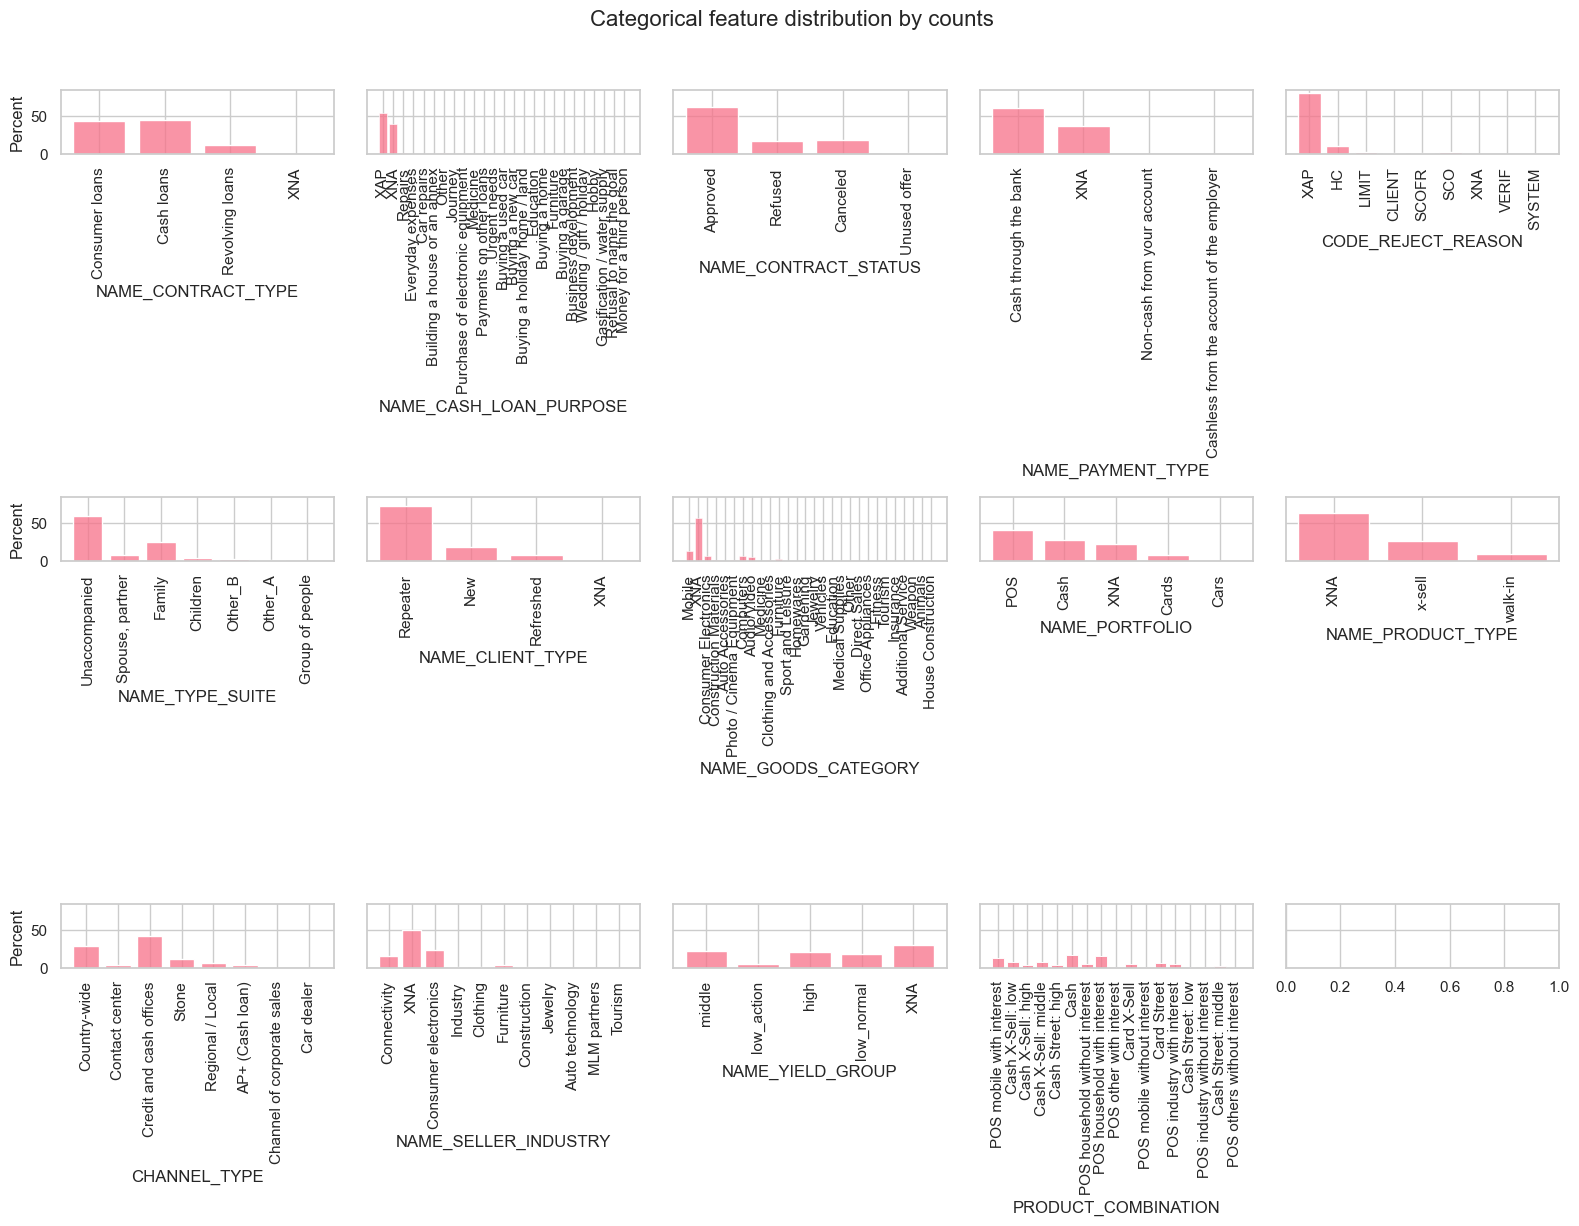

In [6]:
object_columns = previous_application.select_dtypes(
    include=['object']).columns.tolist()


fig, axes = plt.subplots(3, 5, figsize=(16, 12), sharey=True)

axes = axes.flatten()

for i, col in enumerate(object_columns):
    sns.histplot(data=previous_application, x=col, bins=20, multiple="dodge", shrink=.8,
                 ax=axes[i], legend=True, stat="percent")
    axes[i].tick_params(axis='x', rotation=90)

plt.suptitle(f"Categorical feature distribution by counts", size=16, y=1.02)
plt.tight_layout()
plt.show()

When contract type is missing, amount of application is also missing. These values will be dropped.

In [7]:
previous_application[previous_application['NAME_CONTRACT_TYPE'] == 'XNA'].drop(
    columns=['SK_ID_PREV', 'SK_ID_CURR', 'SELLERPLACE_AREA']).drop_duplicates().replace({'XNA': np.nan}).dropna(axis=1)

,AMT_APPLICATION,AMT_CREDIT,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_CLIENT_TYPE,CHANNEL_TYPE
6664,0.0,0.0,1,1,XAP,Canceled,Repeater,Country-wide
17038,0.0,0.0,1,1,XAP,Canceled,New,Country-wide
80232,0.0,0.0,1,1,XAP,Canceled,Refreshed,Country-wide
128265,0.0,0.0,1,1,XAP,Refused,Repeater,Country-wide
317522,0.0,0.0,1,1,XAP,Refused,Repeater,Country-wide
348152,0.0,0.0,1,1,XAP,Canceled,New,AP+ (Cash loan)
722377,0.0,0.0,1,1,XAP,Canceled,New,Credit and cash offices
778611,0.0,0.0,1,1,XAP,Refused,Refreshed,Country-wide
1481269,0.0,0.0,1,1,XAP,Refused,New,Country-wide


In [8]:
previous_application = previous_application[previous_application['NAME_CONTRACT_TYPE'] != 'XNA']

In [9]:
previous_application = help_tool.previous_application_cleaning(
    previous_application)

### NAME_CASH_LOAN_PURPOSE
90% of Cash loans responded with XNA (unknown), while Consumer loans and Revolving loans have subvalues XAP (Application Error). NAME_CASH_LOAN_PURPOSE will be dropped.

In [10]:
previous_application[['NAME_CONTRACT_TYPE', 'NAME_CASH_LOAN_PURPOSE']].value_counts(
) / previous_application[['NAME_CONTRACT_TYPE']].value_counts() * 100

NAME_CONTRACT_TYPE  NAME_CASH_LOAN_PURPOSE          
Cash loans          XNA                                  90.684941
                    Repairs                               3.179039
                    Other                                 2.087879
                    Urgent needs                          1.125271
                    Buying a used car                     0.386327
                    Building a house or an annex          0.360242
                    Everyday expenses                     0.323188
                    Medicine                              0.290816
                    Payments on other loans               0.258309
                    Education                             0.210420
                    Journey                               0.165741
                    Purchase of electronic equipment      0.141930
                    Buying a new car                      0.135375
                    Wedding / gift / holiday              0.128687
         

In [11]:
previous_application.drop(columns='NAME_CASH_LOAN_PURPOSE', inplace=True)

### NAME_PORTFOLIO
NAME_PORTFOLIO has duplicate information for NAME_CONTRACT_TYPE or have missing values, this fetaure will be dropped.

In [12]:
previous_application[['NAME_CONTRACT_TYPE', 'NAME_PORTFOLIO']].value_counts(
) / previous_application[['NAME_CONTRACT_TYPE']].value_counts() * 100

NAME_CONTRACT_TYPE  NAME_PORTFOLIO
Cash loans          Cash              61.743181
                    XNA               38.256819
Consumer loans      POS               94.769259
                    XNA                5.172454
                    Cars               0.058287
Revolving loans     Cards             75.057982
                    XNA               24.942018
Name: count, dtype: float64

In [13]:
previous_application.drop(columns='NAME_PORTFOLIO', inplace=True)

### CODE_REJECT_REASON
'HC' is the biggest caterory for rejection, apart from XAP:
* XAP: Application was approved.
* HC: High Cost – the loan was considered too expensive for the applicant.

### NAME_GOODS_CATEGORY:
* Has no values for Cash Loans and Revolving Loans.
* Values only for Customer Loans. 
NAME_GOODS_CATEGORY will be dropped as values are available only for 1/3 of products.

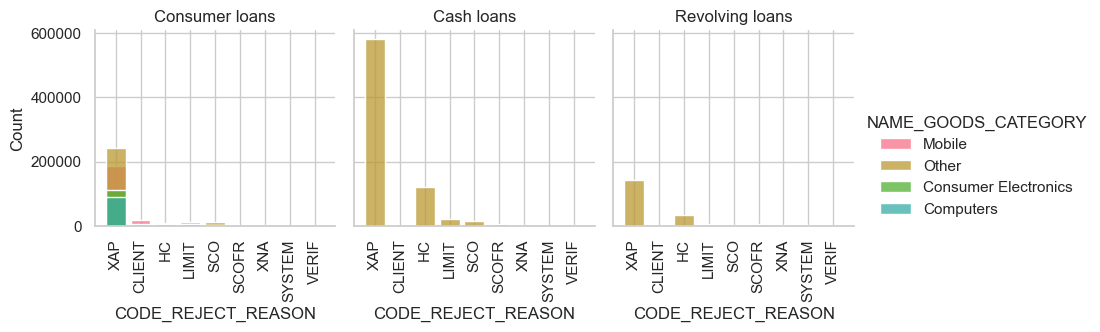

In [14]:
g = sns.FacetGrid(previous_application, col="NAME_CONTRACT_TYPE",  hue="NAME_GOODS_CATEGORY"
                  )
g.map(sns.histplot, 'CODE_REJECT_REASON', bins=20, multiple="dodge", shrink=.8)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.tight_layout()
g.set_xticklabels(rotation=90)
g.add_legend()
plt.show()

In [15]:
previous_application['CODE_REJECT_REASON'] = previous_application['CODE_REJECT_REASON'].apply(
    help_tool.reject_reason)
previous_application.drop(columns='NAME_GOODS_CATEGORY', inplace=True)

PRODUCT_PLACE 'industry' and 'other' will be grouped

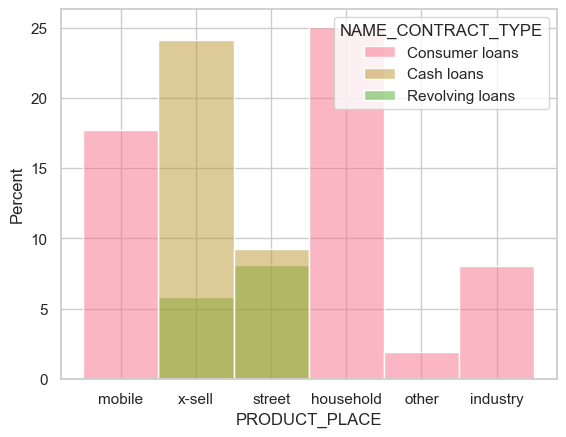

In [16]:
sns.histplot(data=previous_application, x='PRODUCT_PLACE',
             stat='percent', hue='NAME_CONTRACT_TYPE')
plt.show()

In [17]:
previous_application['PRODUCT_PLACE'] = previous_application['PRODUCT_PLACE'].apply(
    help_tool.product_place)

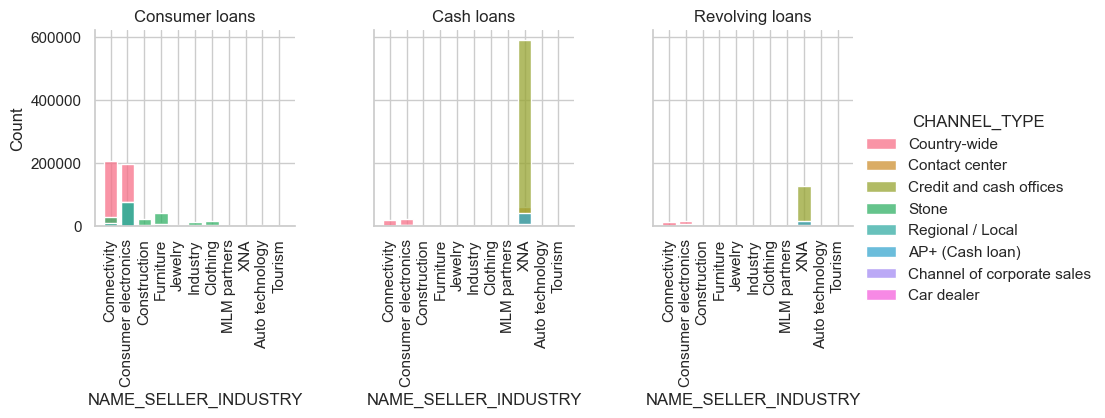

In [18]:
g = sns.FacetGrid(previous_application,
                  col="NAME_CONTRACT_TYPE", hue="CHANNEL_TYPE")
g.map(sns.histplot, 'NAME_SELLER_INDUSTRY',
      bins=20, multiple="dodge", shrink=.8)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.tight_layout()
g.set_xticklabels(rotation=90)
g.add_legend()
plt.show()

In [19]:
previous_application['NAME_SELLER_INDUSTRY'] = help_tool.top_five_categories(
    previous_application, 'NAME_SELLER_INDUSTRY', 3)
previous_application['CHANNEL_TYPE'] = help_tool.top_five_categories(
    previous_application, 'CHANNEL_TYPE', 3)

In [20]:
previous_application.replace({'XNA': np.nan}, inplace=True)

# Partition by Loan type and cluster adding
Feature importance will be created separetly for Loan types. This is done as different loans have different useful features. For example, Cash loans don't have Interest Payment related information, but other types of loans do.

In [54]:
previous_application['NAME_CONTRACT_TYPE'].value_counts(
) / previous_application['NAME_CONTRACT_TYPE'].count() * 100

NAME_CONTRACT_TYPE
Cash loans         44.344794
Consumer loans     44.238100
Revolving loans    11.417106
Name: count, dtype: float64

Loading clustered information.

In [23]:
sorted_credit_card_balance_feature_matrix = help_tool.csv_download(
    r'Archive\home-credit-default-risk\sorted_credit_card_balance_feature_matrix.csv').drop(columns='Unnamed: 0')
sorted_installments_payments_feature_matrix = help_tool.csv_download(
    r'Archive\home-credit-default-risk\sorted_installments_payments_feature_matrix.csv').drop(columns='Unnamed: 0')
application_train = help_tool.csv_download(
    r'Archive\home-credit-default-risk\application_train.csv')[['SK_ID_CURR', 'TARGET']]

In [24]:
previous_application = duckdb.query("""

             SELECT A.*, B.Cluster_credit_card, C.Cluster_installments_payments, D.TARGET
             FROM previous_application A
             LEFT JOIN sorted_credit_card_balance_feature_matrix B ON A.SK_ID_PREV = B.SK_ID_PREV
             LEFT JOIN sorted_installments_payments_feature_matrix C ON A.SK_ID_PREV = C.SK_ID_PREV
             INNER JOIN application_train D ON A.SK_ID_CURR = D.SK_ID_CURR

 """).to_df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [25]:
previous_application[['Cluster_credit_card', 'Cluster_installments_payments']] = previous_application[[
    'Cluster_credit_card', 'Cluster_installments_payments']].astype(object)

Getting feature importance from different portfolios.

In [26]:
def partition_portfolio(df: pd.DataFrame, loan_type: str):

    new_df = df[df['NAME_CONTRACT_TYPE'] == loan_type].drop(
        columns='NAME_CONTRACT_TYPE')

    # Drop non unique columns
    empty_new_df_columns = new_df.columns[new_df.nunique() == 1].to_list()
    new_df.drop(columns=empty_new_df_columns, inplace=True)
    new_df = new_df.dropna(axis=1, how='all')

    feature_importance_new_df = help_model.model_feature_importance_target(
        new_df)

    feature_list = feature_importance_new_df[feature_importance_new_df['importance'] > 100]['feature'].to_list(
    )

    return feature_list

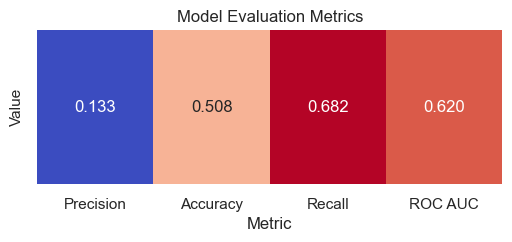

In [27]:
revolving_loans_features = partition_portfolio(
    previous_application, 'Revolving loans')

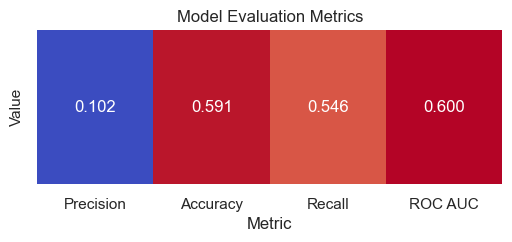

In [28]:
consumer_loans_features = partition_portfolio(
    previous_application, 'Consumer loans')

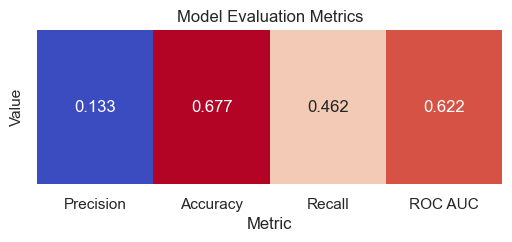

In [29]:
cash_loans_features = partition_portfolio(previous_application, 'Cash loans')

Dummy models for feature importance on different portfolios show promising ROC AUC (0.6) which is close to random guessing (0.5), but slightly better.

Combining all portfolios to feature list

In [30]:
all_features = list(set(revolving_loans_features +
                    consumer_loans_features + cash_loans_features))

### Biserial correlation
Biserial correlation shows no correlation between created features and TARGET.

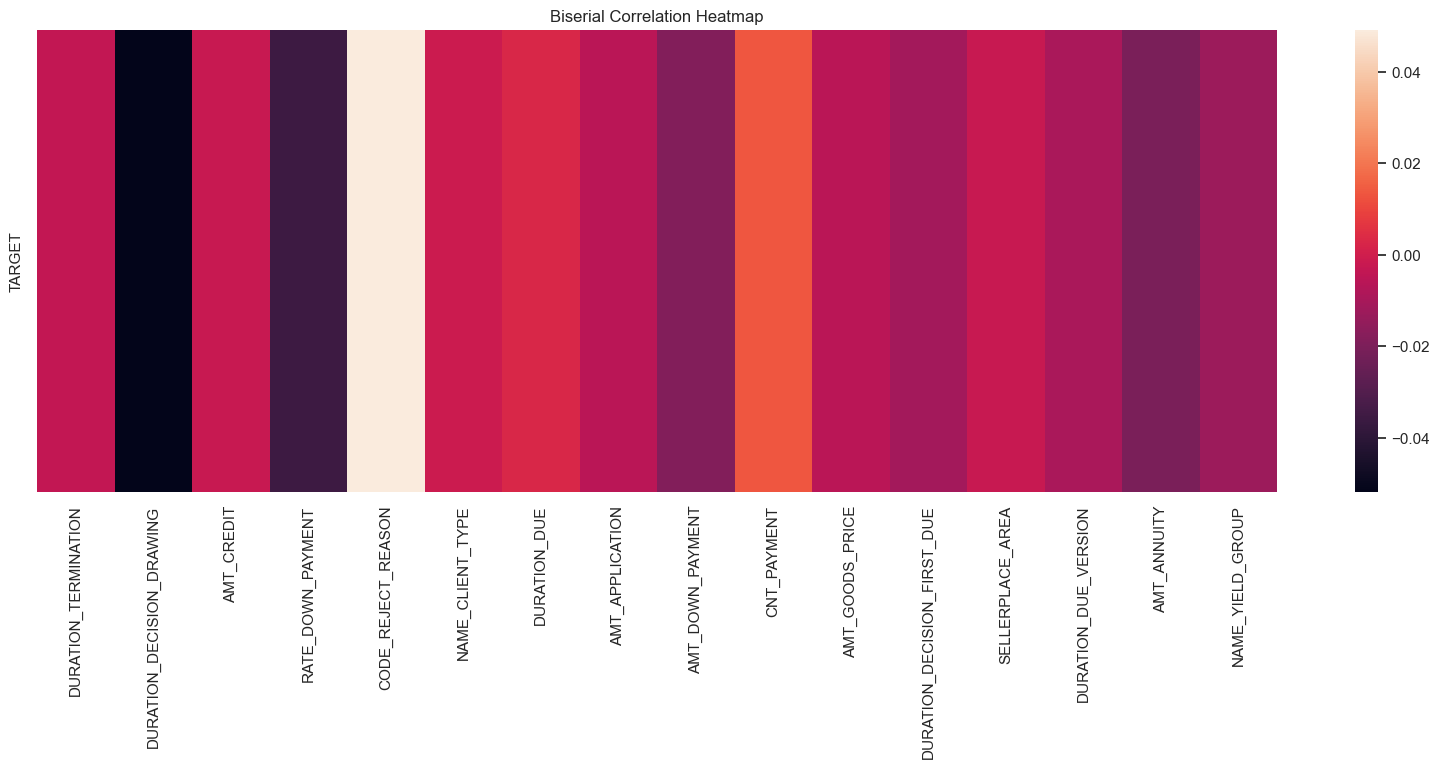

In [33]:
plt.figure(figsize=(20, 6))
help_stats.biserial_heatmap(previous_application[all_features + [
                            'SK_ID_PREV', 'SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE']].fillna(-1), all_features, ['TARGET'])

Creating Ratio between some features.

In [37]:
previous_application[[
    'RATIO_ANNUITY_PAYMENT', 'RATIO_ANNUITY_DOWN_PAYMENT', 'RATIO_ANNUITY_APPLICATION',
    'RATIO_GOODS_PRICE_CREDIT', 'RATIO_SELLERPLACE_AREA_DOWN_PAYMENT'
]] = duckdb.query("""
             SELECT 
             (AMT_ANNUITY / CNT_PAYMENT) AS RATIO_ANNUITY_PAYMENT,
             (AMT_ANNUITY / AMT_DOWN_PAYMENT) AS RATIO_ANNUITY_DOWN_PAYMENT,
             (AMT_ANNUITY / AMT_APPLICATION) AS RATIO_ANNUITY_APPLICATION,
             (AMT_GOODS_PRICE / AMT_CREDIT) AS RATIO_GOODS_PRICE_CREDIT,
             (SELLERPLACE_AREA / AMT_DOWN_PAYMENT) AS RATIO_SELLERPLACE_AREA_DOWN_PAYMENT
             FROM previous_application
""").to_df()


derivative_features = ['RATIO_ANNUITY_PAYMENT', 'RATIO_ANNUITY_DOWN_PAYMENT', 'RATIO_ANNUITY_APPLICATION',
                       'RATIO_GOODS_PRICE_CREDIT', 'RATIO_SELLERPLACE_AREA_DOWN_PAYMENT']

In [38]:
previous_application = previous_application[all_features + derivative_features + [
    'SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'Cluster_credit_card', 'Cluster_installments_payments']]
previous_application_dummie = help_tool.dummy_columns(previous_application, [
                                                      'NAME_CONTRACT_TYPE', 'Cluster_credit_card', 'Cluster_installments_payments'])
previous_application_agg = help_model.aggregated_features(
    previous_application_dummie, 'SK_ID_CURR')

# Feature importance on all Loan types

In [42]:
previous_application_agg = duckdb.query("""
 
             SELECT A.*, B.TARGET
             FROM previous_application_agg A
             LEFT JOIN application_train B
             ON A.SK_ID_CURR = B.SK_ID_CURR

             """).to_df()

previous_application_agg.shape

(291057, 183)

In [43]:
previous_application_agg.drop(columns=(
    previous_application_agg.filter(
        like='MAX(df.NAME_CONTRACT_TYPE_', axis=1).columns.to_list()
    +
    previous_application_agg.filter(
        like='MIN(df.NAME_CONTRACT_TYPE_', axis=1).columns.to_list()
    +
    previous_application_agg.filter(
        like='MEAN(df.NAME_CONTRACT_TYPE_', axis=1).columns.to_list()
), inplace=True)

In [44]:
previous_application_agg.rename(columns={'SUM(df.NAME_CONTRACT_TYPE_Cash loans)': 'Cash_loans',
                                         'SUM(df.NAME_CONTRACT_TYPE_Consumer loans)': 'Consumer_loans',
                                         'SUM(df.NAME_CONTRACT_TYPE_Revolving loans)': 'Revolving_loans'}, inplace=True)

### Biserial correlation
Biserial correlation shows no correlation between created features and TARGET.

c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\scipy\stats\_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


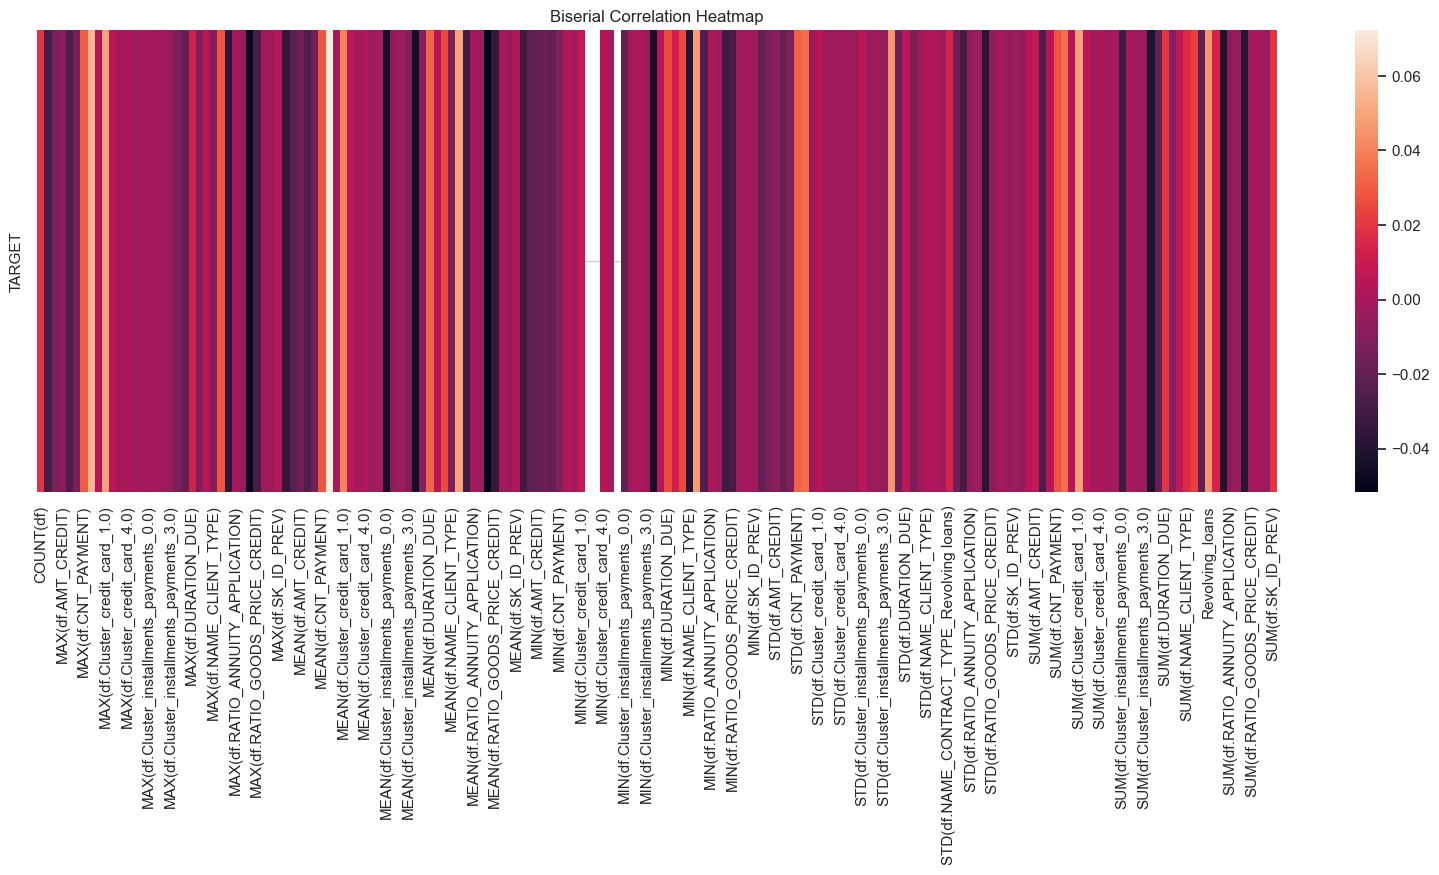

In [45]:
plt.figure(figsize=(20, 6))
help_stats.biserial_heatmap(previous_application_agg.fillna(-1), previous_application_agg.drop(
    columns=['SK_ID_CURR', 'TARGET']).columns.to_list(), ['TARGET'])

### Light GBM

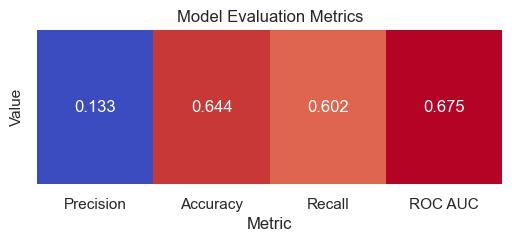

In [46]:
feature_importance_sub_data_clusters = help_model.model_feature_importance_target(
    previous_application_agg.dropna(subset='TARGET'))

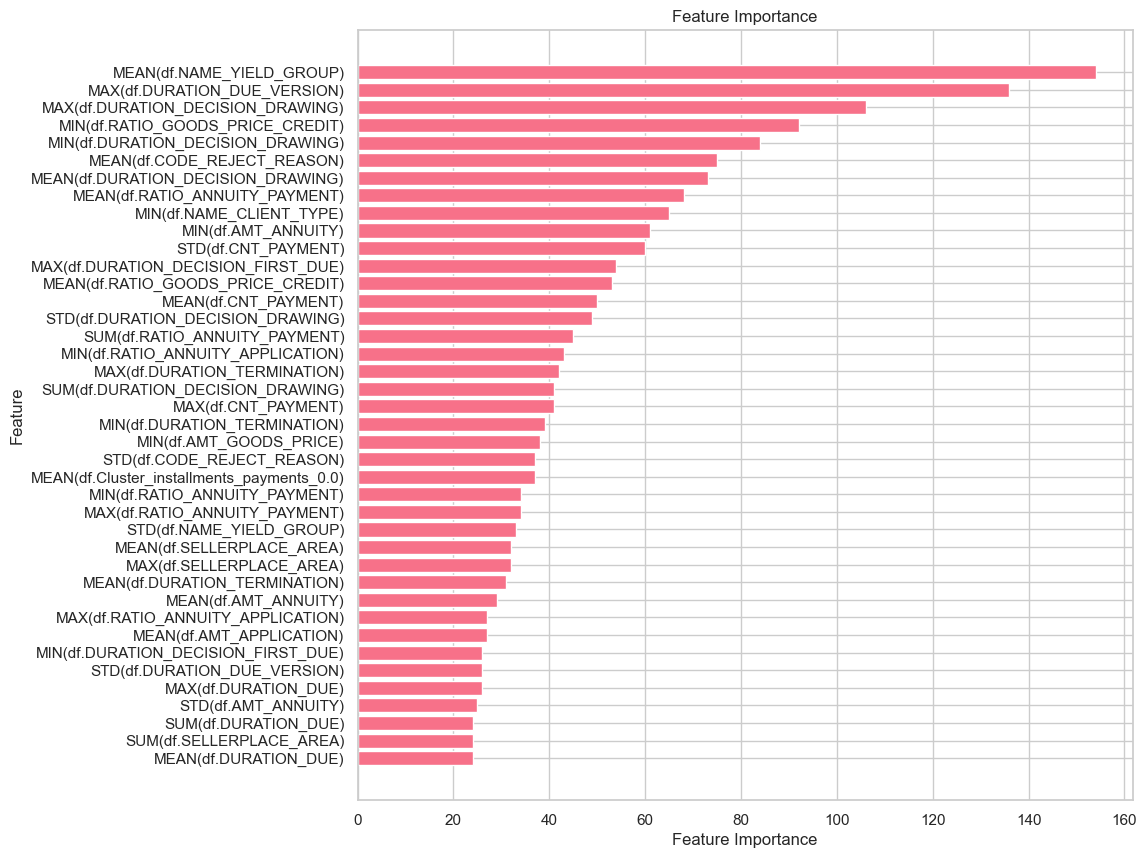

In [47]:
help_model.plot_feature_importance(
    feature_importance_sub_data_clusters.head(40))

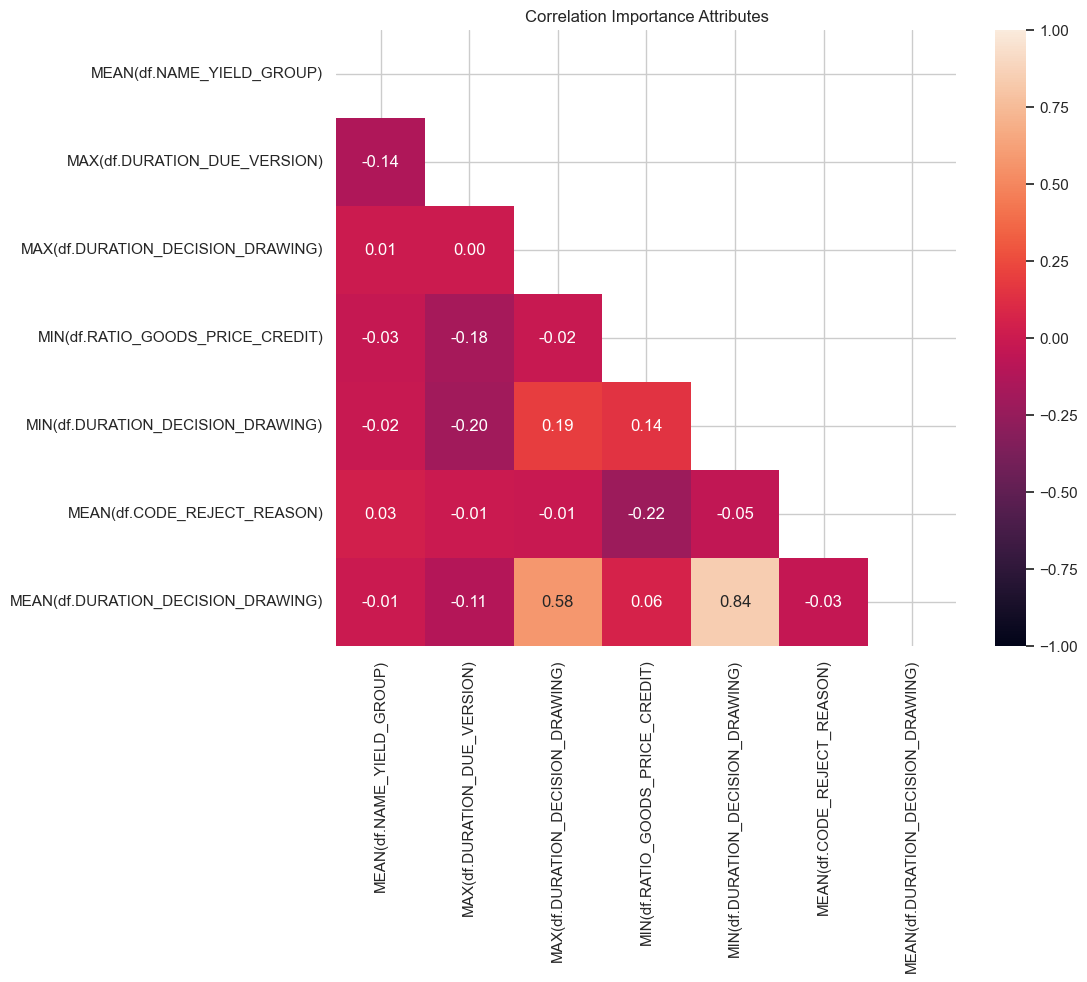

In [48]:
help_visuals.heatmap(previous_application_agg[feature_importance_sub_data_clusters['feature'].head(
    7).to_list()], 'importance', 'pearson')

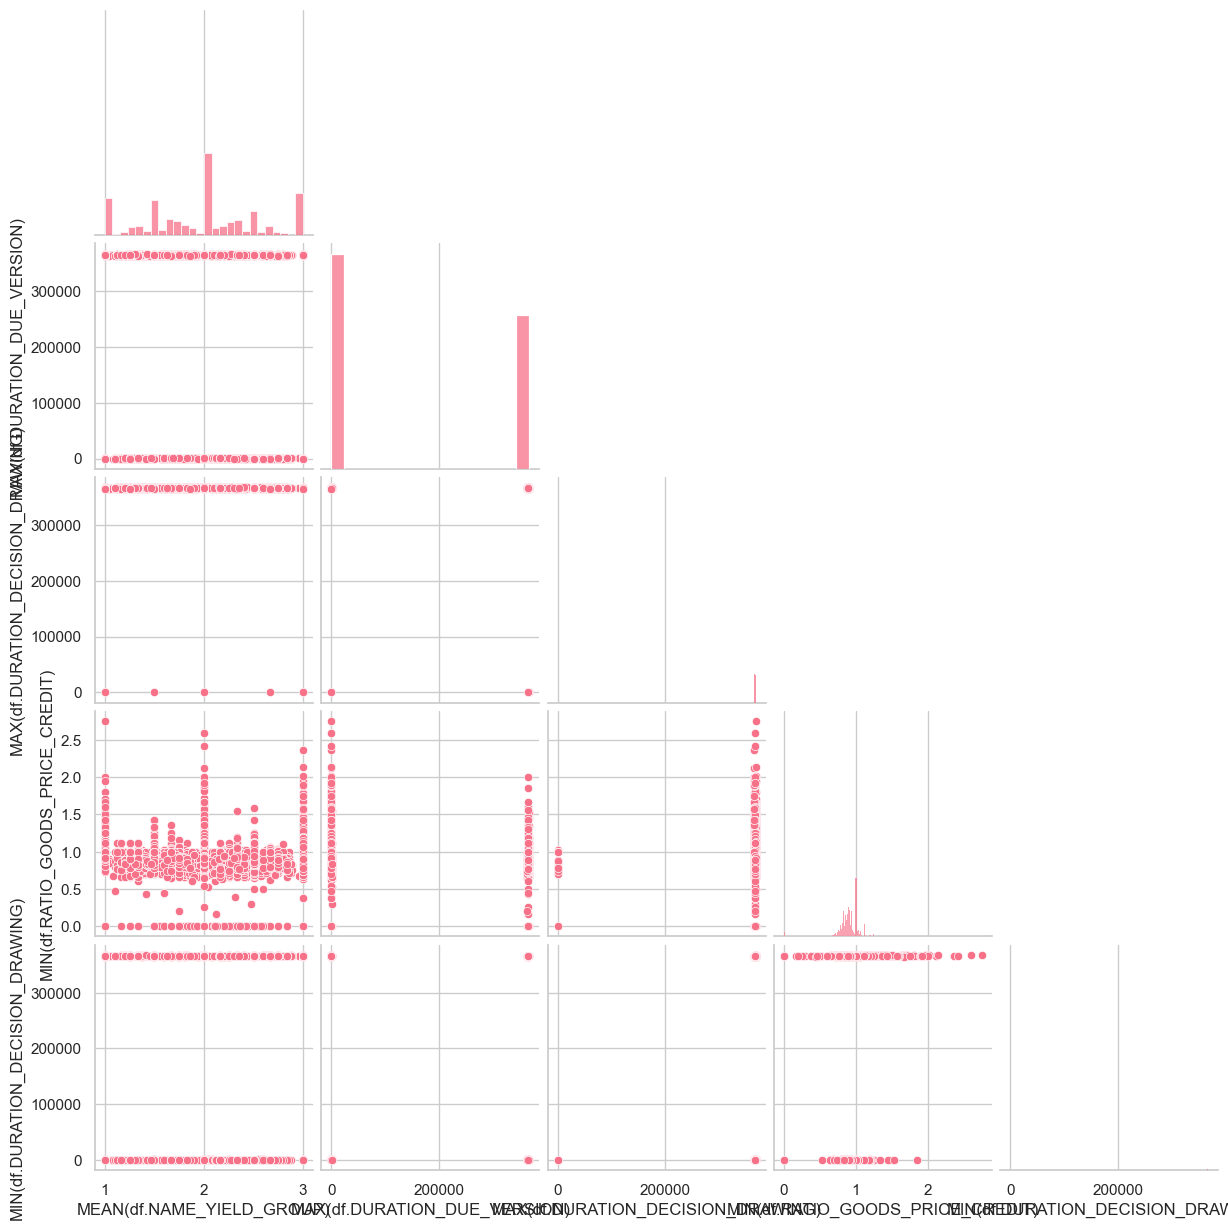

In [51]:
sns.pairplot(c[feature_importance_sub_data_clusters['feature'].head(
    5).to_list()].sample(10000, random_state=42), corner=True)
plt.show()

In [52]:
previous_application_agg[['SK_ID_CURR'] + feature_importance_sub_data_clusters['feature'].head(
    5).to_list()].to_csv(r'Archive\home-credit-default-risk\sub_data_clusters.csv')